# Investment and Trading Project

## Stock Predicton Project Definition

### Project Overview

This is an attempt to predict the stock prices using historical data and applies to the investment and trading domain.
While there are multiple factors that can affect stock pricing – economic, political, social etc., we will
use only the past stock prices themselves to solve a classification problem (buy or sell) or a regression problem (close price). My main motivation for this project is to learn how to effectively solve a time-series problem with a LSTM as the neural network. There have been multiple works in academia that incorporate Recurrent Neural Networks (RNN)and specifically Long Short Term Memory (LSTM) Neural nets for stock market prediction. [1] is an interesting paper where the authors have used different networks to derive useful stats about the stock but finally rely on LSTM to do the prediction. [2] is another paper where LSTM was employed to predict stock prices in the china market. 
In this project, I am primarily interested in stock prices of few semi-conductor companies "WIKI/INTC", "WIKI/QCOM", "WIKI/NVDA", "WIKI/TXN", "WIKI/BRCM", and "WIKI/AAPL". A deep neural network would be trained for each company individually and then used to make prediction on the future stock prices. The input dataset is downloaded using quandl APIs for each of the stocks.

### Datasets and Inputs
This is how the data looks like:
Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
2017-12-20,174.87,175.42,173.25,174.35,23475649.0,0.0,1.0,174.87,175.42,173.25,174.35,23475649.0
2017-12-19,175.03,175.39,174.09,174.54,27436447.0,0.0,1.0,175.03,175.39,174.09,174.54,27436447.0

Dataset has stock prices sinces its inception but i will use only the data starting 2006/1/1 onward.

Apart from the downloaded data from quandl, i will also experiment using some stock indicators such as Relative Strength Index, Average Directional Movement Index, Volatility volume ratio, Simple Moving Average and Stochastic oscillator to create a model that predicts future closing prices.

#### Additional Packages Required:
    quandl - to download stock data
    stockstats - tool to readily create statistics from stock data frame

### Problem Statement

All traders do wish to be able to foretell the price of a particular stock as it amounts to significant wealth (or loss).
There have been many attempts to use statistical analysis and machine learning to predict stock prices.
Here we will attempt to predict future stock prices by using publicly available stock data and using a LSTM neural network. I plan to use a multi-step model building approach to evaluate the model for performance and more importantly a realistic usecase. Stock prediction is essentially a time-series sequence prediction problem and the underlying architecture of a LSTM network makes it a good fit.  

The main questions to answer are:
1. What is predicted Adj Close Adj Close of a stock based on historical data ?
2. What will be the stock price M days into the future ?

We will measure the performance of the deep neural network against a baseline model to understand if we do need a deep neural network. Care will be taken to avoid lookahead bias by clearly splitting the train/test sets using TimeSeriesSplit. We will create models to predict one time-step ahead or multi-time step ahead. While using past data to make prediction is necessary, i will also measure how good are the predictions themselves to predict future values. 
This is essentially a regression problem but we can add a final layer to also make it a classification problem (BUY, SELL, HOLD). The end result would be a model that can predict M days into the future using predictions made N days ahead (M > N)

### Metrics

The main object of the project is to be able to predict the Adjusted Close price of a stock. This is essentially a regression problem and I will use Root Mean Squared Error metric to measure the performance of the model(s). Here we are evaluating the residual error of the prediction and hence RMSE can give the absolute measure of fit for the model. The unit for RMSE is the same as the input and hence it is more intuitive to understand how well it fits the model. A low RMSE score would indicate a better fit to the model.

## Stock Predicton Analysis

### Data Exploration

We begin by downloading the stock prices for the interesting stocks and visualize the closing prices/growth of the stock post 2006. 2006 is just a cut-off used since this would be the more relevant data for prediction. Of all the parameters available for a stock, we will try to understand the Adj. Close price since this is the quantity we are going to predict. The data downloaded from quandl shows a very strong correlation between the close, open, volume, high, low of a stock on a day to day basis. Hence instead of using all the features, i have opted to use only the adj.close as the input feature for the model.

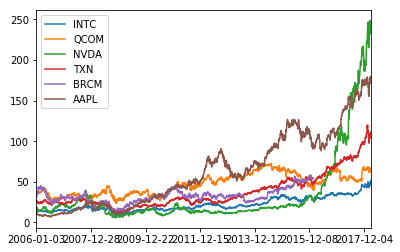

              INTC         QCOM         NVDA          TXN         BRCM  \
count  3065.000000  3065.000000  3066.000000  3066.000000  2536.000000   
mean     21.938068    46.929083    33.577374    37.395884    32.176194   
std       8.484741    12.784241    46.542018    21.256818     8.747484   
min       9.052754    23.535448     5.474608    11.253862    12.668263   
25%      15.542663    34.687172    12.823574    23.698014    26.874654   
50%      18.732004    47.538240    17.367189    28.019929    31.272215   
75%      29.006603    57.085907    23.911975    47.752630    36.029589   
max      52.190000    72.674180   249.080000   120.000000    58.320000   

              AAPL  
count  3065.000000  
mean     62.727955  
std      45.780656  
min       6.511801  
25%      21.252350  
50%      54.284287  
75%      96.692834  
max     179.980000  


In [6]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import capstone_support as cs

stocks = ["INTC", "QCOM", "NVDA", "TXN", "BRCM", "AAPL"]
# download data to local from quandl
# use stockstats https://github.com/jealous/stockstats to record few important
# stats about each of the stocks
cs.download_data(stocks)
# Get Adj.Close of every stock to plot
adj_close_df = cs.get_stocks_df_by_column(stocks)
adj_close_df.plot()
plt.show()
print(adj_close_df.describe())

The graph above shows a good description about how each of our stocks behaved. In terms of the closing price of each stock, we see that there is significant differences between the stocks. NVDA clearly shows a significant change in stock prices during the 2006-2018 period (77% of data is the 4th quartile). However, the closing prices themselves donot help much in understanding trends. We should rather use percentage change to understand stock behavior. Plotted below is a box-plot and a density plot to describe day-on-day percentage change for the 6 stocks.

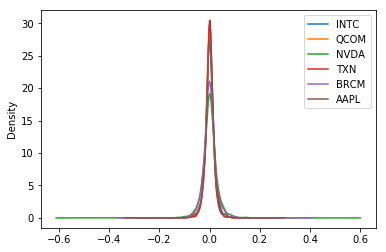

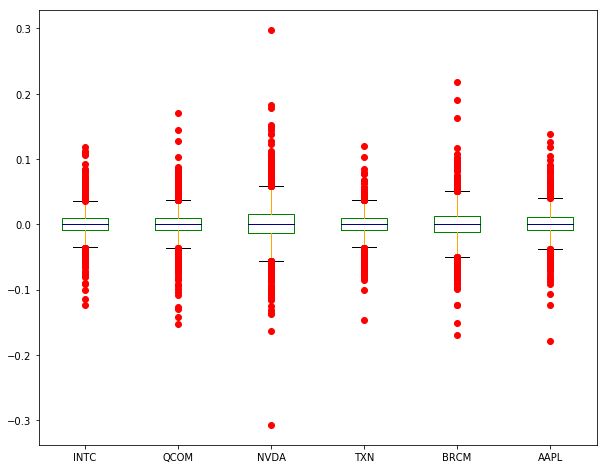

In [7]:
plt.close('all')
pct_change_df = adj_close_df.pct_change()
# plot density plt to see the distribution
pct_change_df.plot.kde()

# a box plot
color = dict(boxes='green', whiskers='orange', medians='DarkBlue', caps='Black')
pct_change_df.plot.box(figsize=(10,8), color=color, sym='ro')

plt.show()

The general trend of all the stocks seems to be in the 1st or the 4th quartile. It clearly shows that the period between 2006 and 2018 had resulted in significant changes in each of the stocks. There are a few obvious steep changes in closing price for NVDA, BRCM seems to be the only outlier in the data.

The correlation matrix plotted below shows that there is not significant correlation between the different stock prices. (Note: A low value means there is very low correlation). The most seems to be between TXN and INTC but even there it is about 66%. This implies that we should be attempting to model each stock independently. We will create models seperately for each stock and hope to predict close prices based on the trained model.

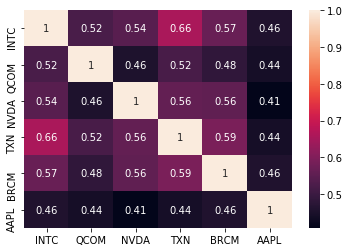

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

corrdata = pct_change_df.corr()

sb.heatmap(corrdata,
            xticklabels=corrdata.columns.values,
            yticklabels=corrdata.columns.values,
          annot=True)
plt.show()

### More input features:
Investment decisions are primarily based on fundamentals or technical analysis. Fundamental analysis use financial information about the company whereas technical analysis uses the stock/market information. Since we are using only the stock prices per-se, we will work on a few techical analysis that identify momentum or trends in a stock and see if the combination of a closing-price and these technical indicators help in predicting future stock prices. A few technical analysis used are:

#### Relative Strength Index (RSI):
RSI is a momentum oscillator i.e. it measures the rate of increase or decrease of stock prices over a period (typically 14 days) and essentially states if a stock is overbought (when above 70) or oversold (when below 30). RSI depends primarily uses the **closing ** price of a stock.
    
#### Average Directional Movement Index (ADMI):
ADMI is a trend indicator i.e. it basically measures the strength or weakness of a trend and hence provides a better judgement on when to enter and exit the market. ADMI also uses the **closing** price of a stock over a period (14-days typically) using either the observed postive or negative Directional Movement. Unlike RSI, it is a lagging indicator i.e. a trend is set before it can be observed.

#### Volatility Volume Ratio (VR):
VR is used to measure price range and is an indicator breakout or changes in the price range. It takes into account the change in **close** prices of a stock along with the **volume**  and calculated over a 26 day period.

#### Simple Moving Average (SMA):
Here we calculate the Simple moving average of **close** price of the stock over 14 days.

#### KDJ Stochastic Oscillator:
This is a stochastic osciallator that determines the undelying strength and direction by analyzing short term movements. It basically takes into account **close**, **high**, **low** and **range** of a stock price for a set period of time (typically 9 days).

##### References:
https://www.investopedia.com/university/technical/

http://www.binaryoptionsthatsuck.com/kdj-stochastic-indicator-can-you-improve-on-perfection/


The idea is to use the above indicators also as input features to a model and understand if these will help us better predict future stock prices.

Eyeballing the plots earlier, we can see that there is some interesting differences between NVDA and QCOM for the period 2016 onward. We can describe and plot these two stocks for the different indicators to look how they behave.

In [9]:
#sample_stocks = ['QCOM', 'NVDA']
close_df = cs.get_stocks_df_by_column(stocks, dateFrom = '2015-01-01')
print(close_df[['QCOM', 'NVDA']].describe())
rsi_df = cs.get_stocks_df_by_column(stocks, columnName = 'RSI', dateFrom = '2015-01-01')
admi_df = cs.get_stocks_df_by_column(stocks, columnName = 'ADMI', dateFrom = '2015-01-01')
vvr_df = cs.get_stocks_df_by_column(stocks, columnName = 'VVR', dateFrom = '2015-01-01')
sma_df = cs.get_stocks_df_by_column(stocks, columnName = 'SMA', dateFrom = '2015-01-01')
stoOsc_df = cs.get_stocks_df_by_column(stocks, columnName = 'StocOsci', dateFrom = '2015-01-01')

             QCOM        NVDA
count  800.000000  801.000000
mean    56.330814   84.428825
std      6.817818   68.637205
min     39.911677   18.588427
25%     51.149011   25.922422
50%     55.854338   56.861016
75%     63.010074  136.912052
max     68.670000  249.080000


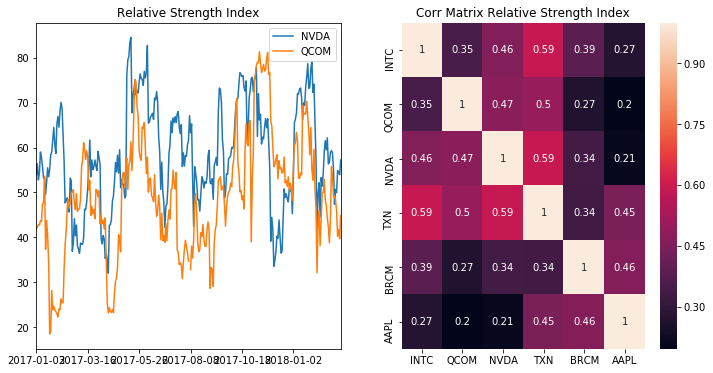

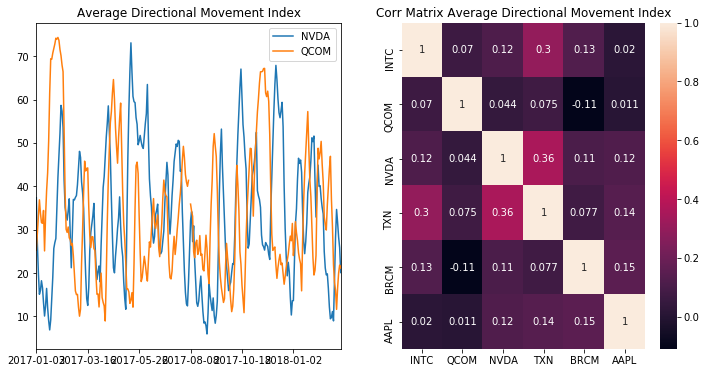

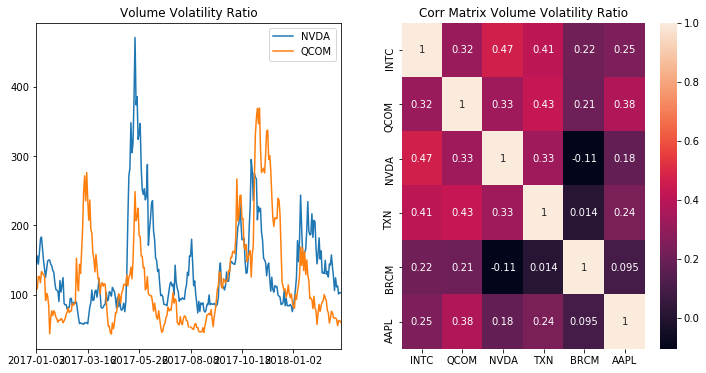

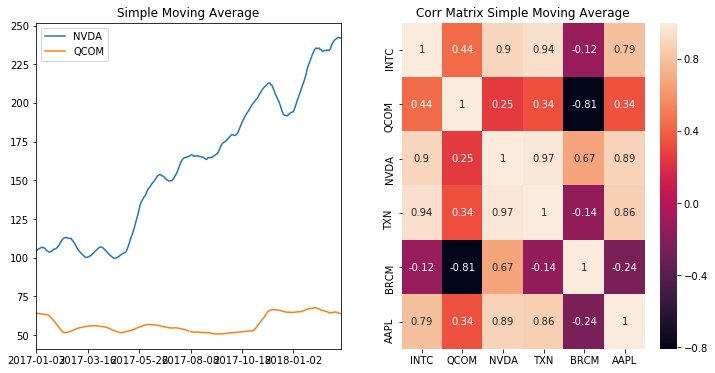

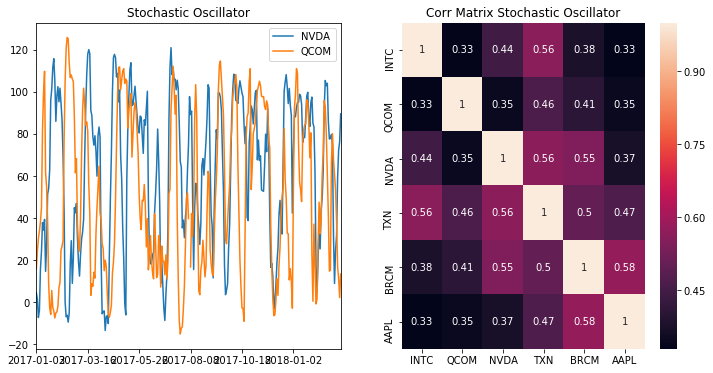

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

sample_stocks = ['NVDA', 'QCOM']
sample_stocks_from = '2017-01-01'
dataframeList = [rsi_df, admi_df, vvr_df, sma_df, stoOsc_df];
titleList = ['Relative Strength Index', 'Average Directional Movement Index', \
             'Volume Volatility Ratio', 'Simple Moving Average', 'Stochastic Oscillator']

plt.close('all')
for idx, frame in enumerate(dataframeList):
    fig, axis = plt.subplots(1,2, figsize=(12,6))
    corrdata = frame.corr()
    frame[sample_stocks][sample_stocks_from:].plot(ax=axis[0], title=titleList[idx])

    axis[1].set_title("Corr Matrix " + titleList[idx])
    sb.heatmap(corrdata,
                xticklabels=corrdata.columns.values,
                yticklabels=corrdata.columns.values,
                ax=axis[1], annot=True)
    plt.show()

The significant oscillations on the indicator for the sample stocks (NVDA & QCOM) is complemented by the correlation matrix which apart from SMA, shows that each of these indicators have very less correlation and therefore capture completely different characteristics of the stock. As a side, below is a correlation plot of the input space for a stock (here AAPL) - which unlike the original inputs (open,close,high,low,volume) - show very less correlation between one another indicating that the increase in input feature space with these indicators would be worth the extra computation.

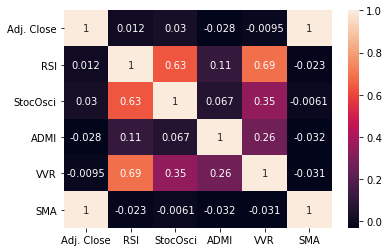

In [11]:
aapl_df = cs.get_stock_dataframe('AAPL')
#print(aapl_df.columns)
aapl_df.drop(['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Volume'], axis=1, inplace=True)
corrdata = aapl_df.corr()

sb.heatmap(corrdata,
            xticklabels=corrdata.columns.values,
            yticklabels=corrdata.columns.values,
          annot=True)
plt.show()

### Algorithms and Techniques

LSTM for house prices: https://arxiv.org/pdf/1709.08432v1.pdf
http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/

Stock market prediction is characterised as a time-series problem and hence we need to ensure that model evaluation is done without lookahead bias i.e. the test set a true test set and was never used in training. We will use Sklearn's TimeSeriesSplit to train using different ratios of train and test data. Additionally, we need to ensure that the event sequence is captured and hence we need to avoid randomizing the input samples.

The input feature space has values with different ranges. Hence we need to normalize the data so that learning will be done in a definite time and that the network will converge to a good minima. We will use MinMax scalar on the train and test sets.

The model will be evaluated using Root Mean Squared Error as this is essentially a regression problem (predict a stock close price in the future). Evaluating the performance of a model for a timeseries problem is a bit tricky in that we would like to evaluate it based on its usage. TimeSeriesSplit can be used to generate multiple splits for example, 40/20, 60/20, 80/20 where we ensure test is done on 20% of the sample after the initial train sample. Note that data must not be shuffled so that we continue to maintain sequence. By testing on a constant sample size, we can aggregate the test result to know a more realistic performance of the model. 

A more realistic way to evaluate the model is by using a rolling forecast or walk-forward validation. In real world usecase, we are more interested in predicting using an online-model i.e. a model which is built on the most recent corpus of data. We decide on a set of samples to be used for training (like the most recent 60 days) and make a prediction for the next (or future) time. With new data, the model is retrained. This is repeated for as many samples required. Note that this would mean we would end up creating many models which is compute intensive.

Stock market prediction can take many forms. We can try to predict the closing-price or generate a buy/sell decision for the next day. However, based on tests i have done and looking at realistic usecases, prediction 1 day in advance is not very interesting. This is because stock-prices generally tend to vary very slightly day-on-day and so the model would choose to weigh the previous day's values more heavily than historical values. In this project, i will try to predict for 14 days in advance for both baseline and final models.

Rolling forecast: https://www.otexts.org/fpp/2/5/
TimeSeries Validation: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

The input data is to be scaled down to a (0 to 1) range. I plan to use LSTM as my final model. However, there is a good chance that a regression algorithm such as Support Vector Regressor performs well.

### Benchmark Model

Considering it is a time-series problem, i plan to predict the same value (rounded to closest decimal) as previous day as the baseline model for the regression problem. 


### Evaluation Metrics

Since this is a time-series problem, i want to ensure that the train and test data are represented as-is i.e. without shuffling. I plan to use sklearn's TimeSeriesSplit. TimeSeriesSplit will allow me to create multiple train/test splits so that I can get more robust estimate. It also has the added advantage extending the training data with test sets that were seen in previous test runs thereby improving the model with more recent data without inducing look ahead bias. Since we want to evaluate on future values, the train split will contain the older 70% of the data. I plan to use Root Mean Square Error (RMSE) as the metric for the regression problem.
To ensure apple-to-apple comparision, we will use the same metric on both the benchmark and the solution model.


### Project Design

This is the work flow i plan to use as part of the Project implementation
#### 1. Data Preprocessing:
The data as-is has many columns which may not be useful. I plan to remove some while adding a few more indicators that mathematically model charactersitics of a stock. Each stock is going to be modelled seperately. We will use Open, High, Low, Close, Volume and a few more variables as input and Adj Close as output. We can also use a moving average for 7 days into the future to predict the stock's Adj close price.

#### 2. Visualize data:
I hope to create some plots such as scatter plots to try to understand any relationship between the different features. A description of my input data set will also help better understand the stats underlying it.

#### 3. Implement Baseline model
Will implement a baseline model using the ideas outlined earlier. This should help me evaluate the final solution model on its performance.

#### 4. Train a Model
The data will then be re-scaled to a (0-1) range before passing it to a model. I plan to build both models using LSTM. Hence, i have to first define the input_dim (batch_size, timesteps, features). The LSTM layer will be followed by a dense layer. I may add dropout to reduce overfitting. I will also use early stopping to avoid creating a model that overfits the data. I plan to use "mae" as the loss function and the "adam" optimizer to compile the model.

#### 5. Evaluate the model
Model evaluation is primarily to understand if the solution model is overfitting or underfitting to the dataset. I would graph the runs for both the training and test data to understand the model characteristic. I may then have to iterate by tuning the model (its layers, hyperparameters etc) to ensure that it is suitable for prediction.

##### 6. Prediction
We are now ready to use the model to predict the Adj. close of the stock. We will need to rescale the prediction output to the actual input values. We can now compare our solution against the baseline model. Predicting a single time step ahead may be more accurate but less useful. So i want to be able to predict a few days ahead. To improve such a prediction, i plan to use a sliding window where predicted values are reused for future prediction.

I do want to create a frontend for the solution where a user can provide a stock ticker and a date-range. This info can be provided via a REST API and the server end would download the necessary data to train a model that can be used to give a prediction. I will give it a shot only if I don't have time/resource constraints. My main objective is to be able to create a decent model based on my learnings from the course.

References:

[1] 
http://snap.stanford.edu/class/cs224w-2015/projects_2015/Predicting_Stock_Movements_Using_Market_Correlation_Networks.pdf

[2] 
http://ieeexplore.ieee.org/document/7364089/

[3] https://etd.auburn.edu/bitstream/handle/10415/5652/Application%20of%20machine%20learning%20techniques%20for%20stock%20market%20prediction.pdf?sequence=2

[4]
https://arxiv.org/pdf/1801.04503.pdf

### Benchmark model
For the benchmark model, i will use the moving average value of the last N days (here N = 14). This is a very realistic benchmark model as stock prices vary ever so slightly on a daily basis. For this model, we are not doing any sort of training and hence we could potential avoid creating a train/test plit. However, doing so will not give an apple-to-apple comparison. Hence we still create a train/test split but use only the test data for evaluation purposes.

In [12]:
## HELPER FUNCTIONS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import datetime

# The stock we are interested in
stock_name = "QCOM"
# Data set includes stock prices beginning at start_date
stock_start_date = '2006-01-01'
# Number of historical days (M) to use for the prediction
# In baseline model, this is used to generate the prediction
# In lstm, this is an input sequence
M_historical_days = 10
# Predict for N days ahead
N_predict_days = 14
# Splits to use for TimeSeriesSplit
timeSeriesSplitCount = 2

def rmse_score(predicted, true_label):
    return math.sqrt(mean_squared_error(true_label, predicted))

def get_datetime_from_str(date_str):
    return datetime.datetime.strptime(date_str, '%Y-%m-%d')

def get_gap_in_months(start_date, end_date):
    return (end_date.year - start_date.year) * 12 + end_date.month - start_date.month

def plot_graph(ax, test_dates, prediction, actual):
    print("Test dates start {} end {}".format(test_dates[0], test_dates[-1]))
    start_date = get_datetime_from_str(test_dates[0])
    end_date = get_datetime_from_str(test_dates[-1])
    num_months = get_gap_in_months(start_date, end_date)
    #print(num_months)

    ax.set_xticklabels('')
    #ax.set_xticks([datetime.date(start_year+int(i/12),1+i%12,1) for i in range(num_months)])
    ax.set_xticks([datetime.date(start_date.year+int(i),1,1) for i in range(1+int(num_months/12))])
    ax.set_xticklabels([datetime.date(start_date.year+int(i),1,1).strftime('%Y')  for i in range(1+int(num_months/12)+1)])
    ax.plot(test_dates.astype(datetime.datetime), prediction, 'r-', label = 'predicted')
    ax.plot(test_dates.astype(datetime.datetime), actual, 'g-.', label = 'actual')
    ax.legend(loc='upper right', shadow=True).get_frame().set_facecolor('0.8')


In [13]:
# class model_base:
#     def __init__(self, Ndays):
#         self.n_days = Ndays
    
#     def prepare(self, train, test, testDates):
#         print("Prepare model data")
    
#     def run(self, X_train, y_train, X_test, y_test):
#         print("RUn model")
    
#     def predict(self, X_test):
#         print("Run model prediction here")

# class baseline_model(model_base):
#     def prepare(self, train, test, testDates):
#         df = pd.DataFrame()
#         for i in range(n_days):
#             closeCol = 'c' + str(i);
#             volCol = 'v' + str(i);
#             df[closeCol] = stock_data.iloc[:]['Adj. Close'].shift(-i)
#             df[volCol] = stock_data.iloc[:]['Adj. Volume'].shift(-i)
#         df['y'] = stock_data.iloc[:]['Adj. Close'].shift(-n_days)
#         #df = df.reset_index().drop(['Date'], axis=1)
#         df = df.dropna()
#         print(df.shape)
#         return df
        
    
# def run_model(model, frame, timeSeriesSplits, Ndays):
#     plt.close('all')
#     fig, ax = plt.subplots(1,splits, figsize=(14,8))

#     dates = frame.index.values
#     df = frame.reset_index().drop(['Date'], axis=1)
#     df = df[['Adj. Close']]
#     TSSplit = TimeSeriesSplit(n_splits=timeSeriesSplits)
#     lstm_scores = []
#     for train_index, test_index in TSSplit.split(df):
#         trainScaler = MinMaxScaler(feature_range=(0, 1))
#         testScaler = MinMaxScaler(feature_range=(0, 1))
#         train, test = df[train_index], df[test_index]
#         trainScaled = trainScaler.fit_transform(train[df.columns])
#         trainScaled = pd.DataFrame(trainScaled, columns=df.columns)
#         testScaled = testScaler.fit_transform(test[df.columns])
#         testScaled = pd.DataFrame(testScaled, columns=df.columns)
#         testDates = dates[test_index]

#         X_train, y_train, X_test, y_test, testDates = model.prepare(trainScaled, testScaled, testDates)
#         model.run(X_train, y_train, X_test, y_test)
#         prediction = model.predict(X_test)
#     plt.show()
#     print(lstm_scores)



In [14]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

def prepareBaselineModelData(stock_data, m_days, n_days):
    df = pd.DataFrame()
    for i in range(m_days):
        closeCol = 'c' + str(i);
#         volCol = 'v' + str(i);
        df[closeCol] = stock_data.iloc[:]['Adj. Close'].shift(-i)
#         df[volCol] = stock_data.iloc[:]['Adj. Volume'].shift(-i)
    df['y'] = stock_data.iloc[:]['Adj. Close'].shift(-(m_days+n_days-1))
    #print(df[:10])
    df = df.dropna()
    #print(df.shape)
    return df

def predictBaselineModel(df, m_days, useAverage=True):
    # predict close as of last known or the mean of n_days
    result = df.drop(['y'], axis=1)
    if (useAverage is True):
        c_cols = []
        for i in range(m_days):
            c_cols.append('c' + str(i))
        result['y'] = df[c_cols].mean(axis=1)
    else:
        col = 'c' + str(m_days-1) # predict last known value
        # col = 'c' + str(1) # predict same days value
        result['y'] = df[:][col]        
    return result
    
def validateBaselineModel(ax, df, m_days, splits, dates):
    tsSplit = TimeSeriesSplit(n_splits=splits)
    baseline_scores = []
    for train_index, test_index in tsSplit.split(df):
        trainScaler = MinMaxScaler(feature_range=(-1, 1))
        testScaler = MinMaxScaler(feature_range=(-1, 1))
        #print("Df shape {} Indexes Train {} Test {}".format(df.shape, len(train_index), len(test_index)))
        #train, test = df[0:len(train_index)], df[len(train_index):len(train_index)+len(test_index)]
        train, test = df.iloc[train_index], df.iloc[test_index]
        train_scaled = trainScaler.fit_transform(train[df.columns])
        train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
        test_scaled = testScaler.fit_transform(test[df.columns])
        test_scaled = pd.DataFrame(test_scaled, columns=df.columns)
        test_dates = dates[len(train_index):len(train_index)+len(test_index)]
        #print("test_dates {} vs dates {}".format(test_dates.shape, dates.shape))

        actual = test_scaled
        predicted = predictBaselineModel(test_scaled, m_days)
        y_hat = testScaler.inverse_transform(predicted)
        y_hat_df = pd.DataFrame(y_hat, columns=predicted.columns)
        y = testScaler.inverse_transform(actual)
        y_df = pd.DataFrame(y, columns=actual.columns)

        #print("Shapes of y_hat {} and y {}".format(y_hat_df['y'].shape, y_df['y'].shape))
        plot_graph(ax[len(baseline_scores)], test_dates, y_hat_df['y'], y_df['y'])

        baseline_scores.append(rmse_score(y_hat_df['y'], y_df['y']))
    print(baseline_scores)
    return baseline_scores


def run_baseline(stock_data, split_count, M_history, N_predict):
    plt.close('all')
    fig, ax = plt.subplots(1, split_count, figsize=(14,8))
    temp_data = stock_data
    stock_frame = prepareBaselineModelData(temp_data, M_history, N_predict)
    stock_dates = stock_frame.index.values
    stock_frame = stock_frame.reset_index().drop(['Date'], axis=1)
    #print(stock_dates.shape)
    #print(stock_frame.shape)
    validateBaselineModel(ax, stock_frame, M_history, split_count, stock_dates)
    plt.show()


Test dates start 2010-01-13 end 2014-01-23
Test dates start 2014-01-24 end 2018-02-05
[2.60424767263038, 3.696717167358234]


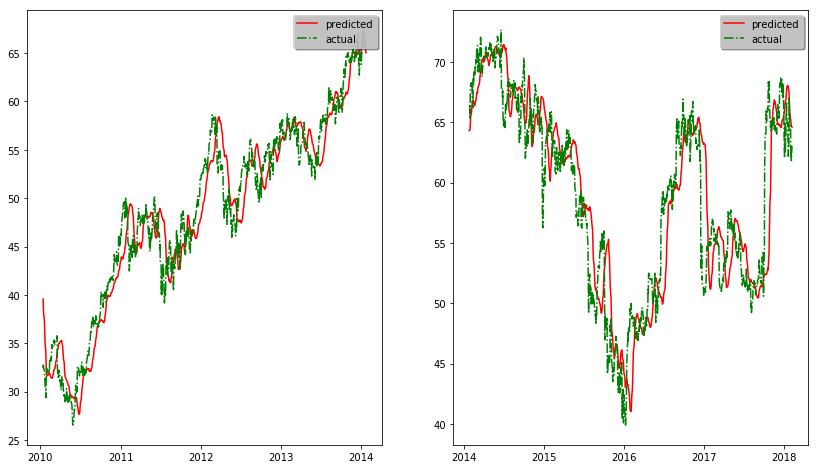

In [15]:
stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
stockdf = stockdf[['Adj. Close']]
run_baseline(stockdf, timeSeriesSplitCount, M_historical_days, N_predict_days)


In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras import backend

def rmse_metric(y, y_hat):
    return backend.sqrt(backend.mean(backend.square(y_hat - y), axis=-1))

def prepareLSTMModelData(stockdf, timesteps):
    num_samples = stockdf.shape[0] - (timesteps)
    num_features = stockdf.shape[1]
    X_train = np.zeros((num_samples, timesteps, num_features))
    y_train = np.zeros((num_samples))
    
    for i in range(num_samples):
        y_pos = i + timesteps
        X_train[i] = stockdf[i:y_pos]
        y_train[i] = stockdf['Adj. Close'][y_pos]

    return (X_train, y_train)

def validateLSTMModel(ax, df, m_days, n_days, splits, dates, \
                      neurons=20, num_epochs=1, mBatches=1, mStateFul=False, lossFn='mae', modelOptimizer='adam'):
    tsSplit = TimeSeriesSplit(n_splits=splits)
    lstm_scores = []
    for train_index, test_index in tsSplit.split(df):
        scaler_train = MinMaxScaler(feature_range=(-1, 1))
        scaler_test = MinMaxScaler(feature_range=(-1, 1))
        train, test = df[0:len(train_index)], df[1+len(train_index):1+len(train_index)+len(test_index)]
        train_scaled = scaler_train.fit_transform(train[df.columns])
        train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
        test_scaled = scaler_test.fit_transform(test[df.columns])
        test_scaled = pd.DataFrame(test_scaled, columns=df.columns)

        X_train, y_train = prepareLSTMModelData(train_scaled, m_days)
        X_test, y_test = prepareLSTMModelData(test_scaled, m_days)
        test_dates = dates[1+len(train_index)+m_days:1+len(train_index)+len(test_index)]

        print("X train {} and test {}".format(X_train.shape, X_test.shape))
        print("Y train {} and test {}".format(y_train.shape, y_test.shape))
        print("Test dates {}".format(test_dates.shape))
        model = Sequential()
        if (mStateFul == True):
            model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]),\
                    return_sequences=True, \
                    stateful=True, batch_size=mBatches))
        else:
            model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]),\
                       return_sequences=True))
        #model.add(LSTM(20, return_sequences=True))
        model.add(LSTM(neurons))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=lossFn, optimizer=modelOptimizer, metrics=[rmse_metric])
        print(model.summary())
        history = None
        for i in range(num_epochs):
            history = model.fit(X_train, y_train, #validation_data=(X_test, y_test),
                  epochs=1, batch_size=mBatches, verbose=2)
            model.reset_states()
        print(history.history.keys())
        predicted = model.predict(X_test, batch_size=1)

        y_test = y_test.reshape(-1,1)
        print("Reshaped predicted {} and y_test {}".format(predicted.shape, y_test.shape))

        y_hat = scaler_test.inverse_transform(predicted)
        y_hat_df = pd.DataFrame(y_hat, columns=["y_hat"])
        y_actual = scaler_test.inverse_transform(y_test)
        y_actual_df = pd.DataFrame(y_actual, columns=["y"])
        labels_df = pd.concat([y_hat_df, y_actual_df], axis=1)
        print("test_dates shape {} vs y_hat shape {} vs y_test shape {}" \
              .format(test_dates.shape, y_hat.shape, y_test.shape))

        print(labels_df[:5])
        print(predicted[:5])
        print(y_test[:5])

        if ax is not None:
            print("Plot graph here")
            #plot_graph(ax[len(lstm_scores)], test_dates, y_hat, y_actual)
            # summarize history for loss
            #ax[len(lstm_scores)].plot(history.history['rmse_metric'])
            #ax[len(lstm_scores)].plot(history.history['val_rmse_metric'])

            #ax[len(lstm_scores)].plot(history.history['mean_squared_error'])
            #ax[len(lstm_scores)].plot(history.history['val_mean_squared_error'])
            #         ax[len(lstm_scores)].title('model loss')
            #         ax[len(lstm_scores)].ylabel('loss')
            #         ax[len(lstm_scores)].xlabel('epoch')
            #         ax[len(lstm_scores)].legend(['train', 'test'], loc='upper left')
        lstm_scores.append(rmse_score(y_hat_df['y_hat'], y_actual_df['y']))
    print(lstm_scores)
    return lstm_scores

def run_lstm(stock_data, split_count, M_history, N_predict):
    plt.close('all')
    fig, ax = plt.subplots(1, split_count, figsize=(14,8))
    stock_frame = stock_data
    stock_dates = stock_frame.index.values
    validateLSTMModel(ax, stock_frame, M_history, N_predict, split_count, stock_dates)
    plt.show()

def experiment_lstm_parameters(stock_data):
    stock_frame = stock_data[:50]
    stock_dates = stock_frame.index.values
    dataSplits = 2
    experiment_df = pd.DataFrame()
    historyList = [14, 30, 60, 100]
    neuronList = [1, 5, 10, 30]
    statefulList = [False, True]
    epochList = [1, 10, 100, 500]
    lossFnList = ['mae', 'mse']
    optimizerList = ['adam', 'sgd', 'rmsprop', 'adadelta']
    batchSizeList = [1, 10, 30]
    totalIterations = len(historyList)*len(neuronList)*len(statefulList)
    totalIterations *= len(epochList)*len(lossFnList)*len(optimizerList)*len(batchSizeList)
    i = 0
    for history in [2]:#[14, 30, 60, 100]:
        for neurons in [30]:#[1, 5, 10, 30]:
            for stateful in [False, True]:
                for epochs in [1]:#, 100, 500]:
                    for lossFunction in ['mse']:
                        for optimizer in ['sgd', 'rmsprop']:
                            for batchSize in [1, 10]:
                                if (batchSize > 1 and stateful is True):
                                    continue
                                expStr = "{}-{}-{}-{}-{}-{}-{}".format(history, stateful, neurons,\
                                                    epochs, lossFunction, optimizer, batchSize)
                                print(expStr)
                                i = i + 1
                                print("Iteration {} of {}".format(i, totalIterations))
                                result = validateLSTMModel(None, stock_frame, history, 14, dataSplits, stock_dates, \
                                                 neurons, epochs, batchSize, stateful, lossFunction)
                                experiment_df[expStr] = result
    experiment_df.to_csv()


In [35]:
# stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
# stockdf = stockdf[['Adj. Close']]
# run_lstm(stockdf, timeSeriesSplitCount, M_historical_days, N_predict_days)


In [ ]:
stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
stockdf = stockdf[['Adj. Close']]
experiment_lstm_parameters(stockdf)

2-False-30-1-mse-sgd-1
Iteration 1 of 3072
X train (16, 2, 1) and test (14, 2, 1)
Y train (16,) and test (14,)
Test dates (14,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 2, 30)             3840      
_________________________________________________________________
lstm_100 (LSTM)              (None, 30)                7320      
_________________________________________________________________
dropout_48 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 31        
Total params: 11,191.0
Trainable params: 11,191.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
9s - loss: 0.3261 - rmse_metric: 0.5112
dict_keys(['rmse_metric', 'loss'])
Reshaped predicted (14, 1) and y_test (14, 1)


In [ ]:
# 14 day history with linear activation, mse metric
#[1.1974612701277736, 1.9487309120402392]
#[0.9301565878001333, 1.0692067255164426] stateful, neuron 20, 2 layer lstm, batch_size=1
# [1.161702460648902, 1.2634392663148677] non-stateful, neuron 20, 2 layer lstm, batch_size=1
# 60 day history with linear activation
# non-stateful, neuron 20, 2 layer lstm, batch_size=1
# 60 day history with tanh activation
